# Dog vs Cat Classification

In [45]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# setting memory growth to prevent "out of memory" error
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# reading the data from local file
path = "../datasets/Cat&Dog/"
data = tf.keras.preprocessing.image_dataset_from_directory(path)

Found 10028 files belonging to 2 classes.


In [4]:
data.as_numpy_iterator().next()[0].shape # all the images have the same shape 

(32, 256, 256, 3)

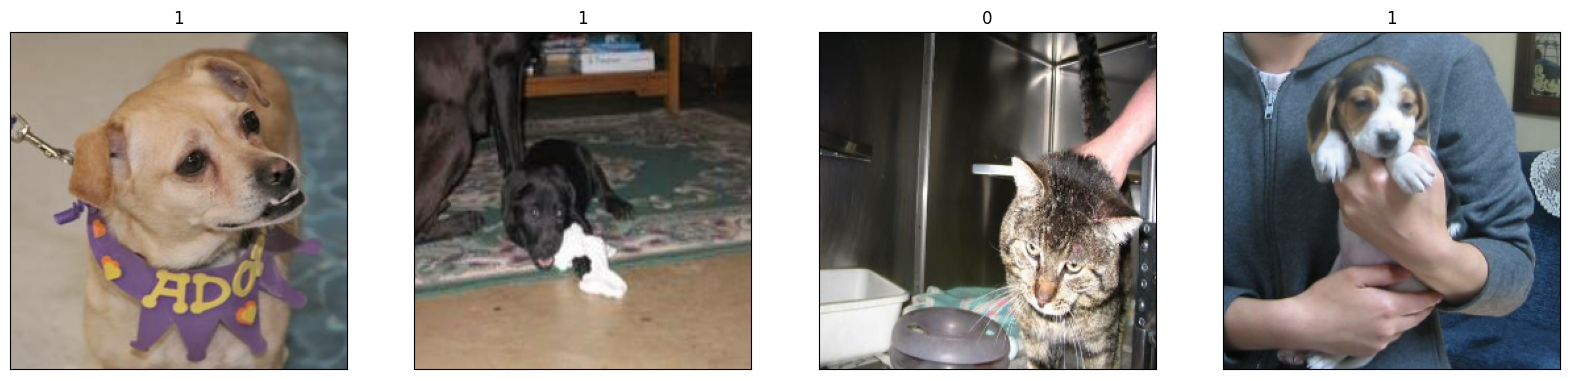

In [5]:
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for index, image in enumerate(batch[0][:4]):
    ax[index].imshow(image.astype(int))
    ax[index].tick_params(left = False, right = False , labelleft = False, 
                    labelbottom = False, bottom = False) 
    ax[index].title.set_text(batch[1][index])
    

In [6]:
# scaling the data between 0 and 1
data = data.map(lambda x, y: (x/255, y))

In [7]:
data.as_numpy_iterator().next()[0].max()

1.0

In [8]:
len(data)

314

In [9]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 2
test_size = int(len(data) * 0.1)

train_size + val_size + test_size

314

In [10]:
# spliting the data to train, validation and test datasets
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [11]:
len(train) + len(validation) + len(test) 

314

In [12]:
# preprocessing steps for speeding things up
train = train.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [64]:
model = Sequential([

Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.3),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.3),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.4),

Conv2D(256, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.4),

Conv2D(512, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.5),

Flatten(),

Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),

Dense(256, activation='relu'),
BatchNormalization(),
Dropout(0.5),

Dense(1, activation='sigmoid')
])


In [65]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)

In [67]:
hist = model.fit(train, validation_data=validation, epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
219/219 [==============================] - 24s 102ms/step - loss: 0.8510 - accuracy: 0.5666 - val_loss: 1.9645 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - 22s 101ms/step - loss: 0.6812 - accuracy: 0.6233 - val_loss: 0.7380 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - 22s 101ms/step - loss: 0.5994 - accuracy: 0.6779 - val_loss: 1.0077 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - 22s 101ms/step - loss: 0.5578 - accuracy: 0.7138 - val_loss: 0.7545 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 5/20
219/219 [==============================] - 22s 101ms/step - loss: 0.5264 - accuracy: 0.7346 - val_loss: 0.6067 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 6/20
219/219 [==============================] - 22s 101ms/step - loss: 0.4881 - accuracy: 0.7549 - val_loss: 0.5668 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 7/20
219/219 [==============================] 

In [68]:
model.evaluate(test)

31/31 [==============================] - 1s 38ms/step - loss: 0.4046 - accuracy: 0.8693


[0.404554158449173, 0.8693415522575378]

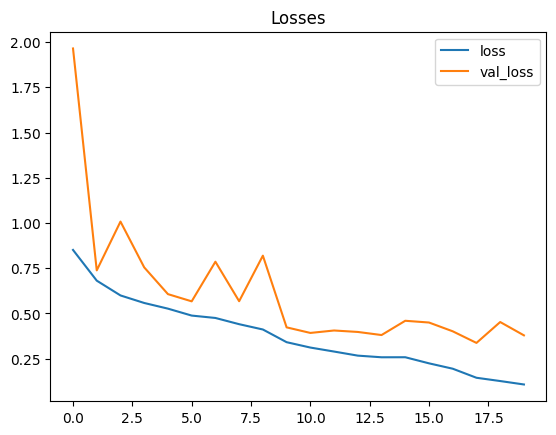

In [89]:
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("Losses")
plt.legend()
plt.show()

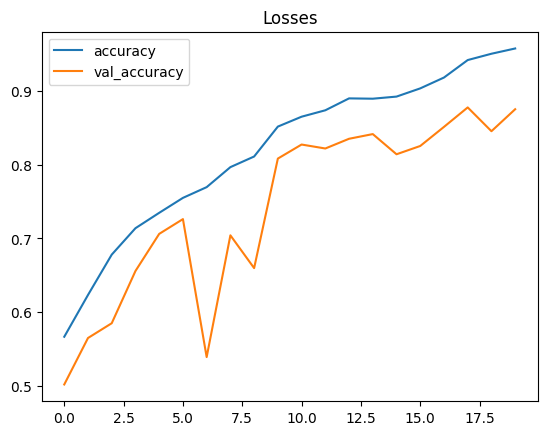

In [90]:
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.title("Losses")
plt.legend()
plt.show()

In [84]:
def predict(img_array):
    img_batch = tf.expand_dims(img_array, 0)
    pred = model.predict(img_batch)

    if pred > 0.5:
        return "dog"

    else:
        return "cat"

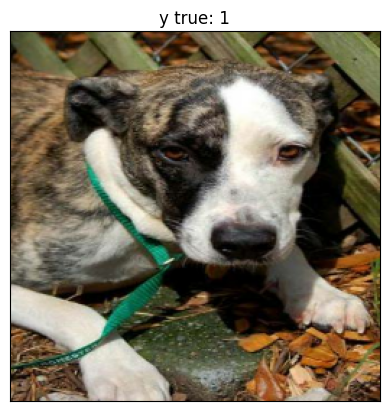

1/1 [==============================] - 0s 19ms/step
dog


In [87]:
batch = test.as_numpy_iterator().next()
image =(batch[0][0] * 255).astype(int)
plt.imshow(image)
plt.title(f"y true: {batch[1][0]}")
plt.tick_params(left = False, right = False , labelleft = False, 
                    labelbottom = False, bottom = False)
plt.show()

print(predict(image))

# Face/Age Detection 

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd 
import numpy as np
import cv2
import os

In [55]:
images_path = "../datasets/Age Detection/faces/Train/"
csv_path = "../datasets/Age Detection/faces/train.csv"

In [56]:
df = pd.read_csv(csv_path)
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [57]:
class_mapping = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}
df["Class"] = df["Class"].map(class_mapping)
df.head()

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1
3,16496.jpg,0
4,4487.jpg,1


In [58]:
# using tensorflow input pipeline 
# images_path = tf.data.Dataset.list_files(images_path, shuffle=False)

In [59]:
# applying data augmentation layers using Keras
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

In [60]:
# This function simply loads images from local files 
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0 
    image =  data_augmentation(image)
    return image, label 

# This function creates a tensorflow data pipeline and applies preprocessing steps
def create_tf_dataset(df, batch_size=32):
    image_paths = df['ID'].apply(lambda x: images_path + x)
    labels = df['Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths.values, labels))
    dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE).shuffle(2000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

data = create_tf_dataset(df)

(128, 128, 3)


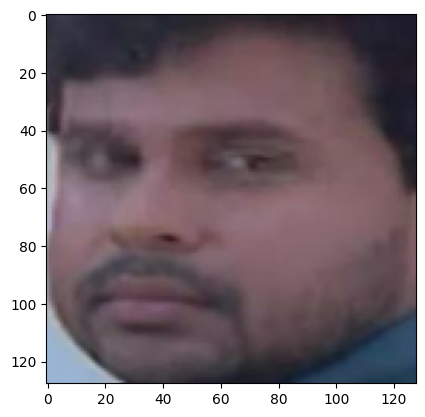

In [61]:
img = data.as_numpy_iterator().next()[0][0]
print(img.shape)
plt.imshow((img * 255).astype(int))
plt.show()

In [62]:
len(data)

623

In [63]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

train_size + val_size + test_size

623

In [64]:
# Splitting the dataset to train, test, and validation sets
train_ds = data.take(train_size)
validation_ds = data.skip(train_size).take(val_size)
test_ds = data.skip(train_size + val_size)

In [73]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Add Dropout

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [74]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
hist = model.fit(train_ds, validation_data=validation_ds, epochs=35, callbacks=[early_stopping, reduce_lr])

Epoch 1/35
436/436 [==============================] - 17s 35ms/step - loss: 0.9132 - accuracy: 0.5803 - val_loss: 0.8083 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 2/35
436/436 [==============================] - 16s 35ms/step - loss: 0.8042 - accuracy: 0.6411 - val_loss: 0.7668 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 3/35
436/436 [==============================] - 16s 36ms/step - loss: 0.7637 - accuracy: 0.6647 - val_loss: 0.7488 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 4/35
436/436 [==============================] - 16s 36ms/step - loss: 0.7396 - accuracy: 0.6704 - val_loss: 0.7927 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 5/35
436/436 [==============================] - 16s 36ms/step - loss: 0.7168 - accuracy: 0.6864 - val_loss: 0.7342 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 6/35
436/436 [==============================] - 16s 36ms/step - loss: 0.6810 - accuracy: 0.7074 - val_loss: 0.6741 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 7/35
436/436 [==============================] - 17s 

In [76]:
model.evaluate(test_ds)

62/62 [==============================] - 8s 11ms/step - loss: 0.7738 - accuracy: 0.8081


[0.7737626433372498, 0.8080859780311584]

In [85]:
# Testing the model on an image of myself 
from tensorflow.keras.preprocessing import image

img_path = "test.jpg"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)

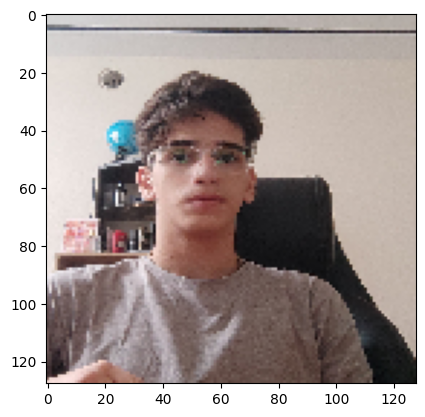

In [86]:
plt.imshow(img)
plt.show()

In [84]:
pred = model.predict(img_array)

pred_class = np.argmax(pred)
pred_class

1/1 [==============================] - 0s 20ms/step


1